# <center>Data Analytics laboratory </center>

## <center>Using link functions to create generalized linear models</center>

In [48]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as npx
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [49]:
airline_data = pd.read_csv('Airline_data.csv')
airline_data

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0
5,1981,21,362,6033.0
6,1982,26,764,5877.0
7,1983,20,809,6223.0
8,1984,16,223,7433.0
9,1985,22,1066,7107.0


### Task 1

In [50]:
%%writefile airline.stan

data {
  int<lower=0> N;
  int<lower=0> y[N];
  vector<lower=0>[N] n;
}

parameters {
  real alpha;
  real theta;
}

model {
  alpha ~ normal(0, 5);
  theta ~ normal(0, 5);
  for (i in 1:N)
    y[i] ~ poisson_log(alpha + theta * log(n[i]));
}

generated quantities {
  real lambda[N];
  for (i in 1:N)
    lambda[i] = exp(alpha + theta * log(n[i]));
}

Overwriting airline.stan


In [51]:
model = CmdStanModel(stan_file='airline.stan')
fit = model.sample(data={'N': len(airline_data), 'y': airline_data['Fatal accidents'].values, 'n': airline_data['Miles flown [100 mln miles]'].values}, output_dir='output', seed=123)


INFO:cmdstanpy:compiling stan file /airline.stan to exe file /airline
INFO:cmdstanpy:compiled model executable: /airline
--- Translating Stan model to C++ code ---
bin/stanc  --o=/airline.hpp /airline.stan
Warning in '/airline.stan', line 4, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc
Warning in '/airline.stan', line 21, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/


INFO:cmdstanpy:CmdStan done processing.


      lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  divergent__  \
0  515.907       0.981803    0.021094          7.0         171.0          0.0   
1  516.158       0.999803    0.021094          5.0          59.0          0.0   
2  516.144       0.960696    0.021094          4.0          19.0          0.0   
3  516.312       0.990297    0.021094          7.0         163.0          0.0   
4  515.374       0.944499    0.021094          7.0         135.0          0.0   

   energy__    alpha     theta  lambda[1]  lambda[2]  lambda[3]  lambda[4]  \
0  -515.501  8.27225 -0.596396    28.4031    26.6445    24.2743    23.0543   
1  -515.525  7.98532 -0.556054    29.7479    28.0269    25.6952    24.4890   
2  -515.888  8.04456 -0.567600    28.6928    26.9994    24.7086    23.5253   
3  -514.904  3.80429 -0.070514    25.0757    24.8869    24.6143    24.4647   
4  -514.010  1.76513  0.165547    22.9293    23.3397    23.9511    24.2964   

   lambda[5]  lambda[6]  lambda[7]  lambda[8

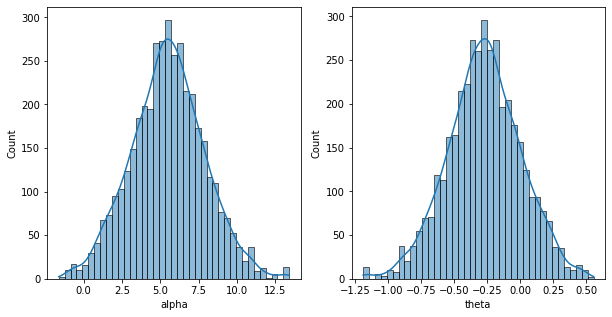

In [52]:
print(fit.draws_pd().head())
# Plot posterior distributions of alpha and theta
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
sns.histplot(fit.draws_pd()['alpha'], kde=True, ax=axes[0])
sns.histplot(fit.draws_pd()['theta'], kde=True, ax=axes[1])
axes[0].set_xlabel('alpha')
axes[1].set_xlabel('theta')
plt.show()


In [53]:
# Compile the model
poisson_model = CmdStanModel(stan_file='airline.stan')

# Set up the data dictionary
N = len(airline_data)
data = {'N': N, 'y': airline_data['Fatal accidents'].values, 'n': airline_data['Miles flown [100 mln miles]'].values}

# Fit the model to the data
fit = poisson_model.sample(data=data, chains=4)

# Print summary statistics for the posterior samples
print(fit.summary())


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.



              Mean   MCSE  StdDev      5%     50%     95%   N_Eff  N_Eff/s  \
name                                                                         
lp__        520.00  0.036    0.96  510.00  520.00  520.00   720.0   1500.0   
alpha         5.60  0.110    2.40    1.60    5.50    9.60   490.0   1000.0   
theta        -0.28  0.013    0.28   -0.75   -0.28    0.19   490.0   1000.0   
lambda[1]    26.00  0.130    3.20   22.00   26.00   32.00   623.0   1326.0   
lambda[2]    26.00  0.089    2.50   22.00   26.00   30.00   761.0   1619.0   
lambda[3]    24.00  0.041    1.70   22.00   24.00   27.00  1703.0   3624.0   
lambda[4]    24.00  0.025    1.50   21.00   24.00   26.00  3757.0   7993.0   
lambda[5]    23.00  0.028    1.50   21.00   23.00   26.00  2913.0   6197.0   
lambda[6]    23.00  0.034    1.60   21.00   23.00   26.00  2123.0   4516.0   
lambda[7]    23.00  0.030    1.50   21.00   23.00   26.00  2664.0   5668.0   
lambda[8]    23.00  0.041    1.60   20.00   23.00   26.00  1644

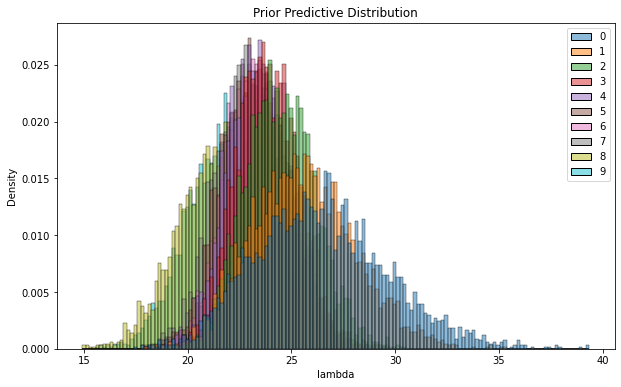

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


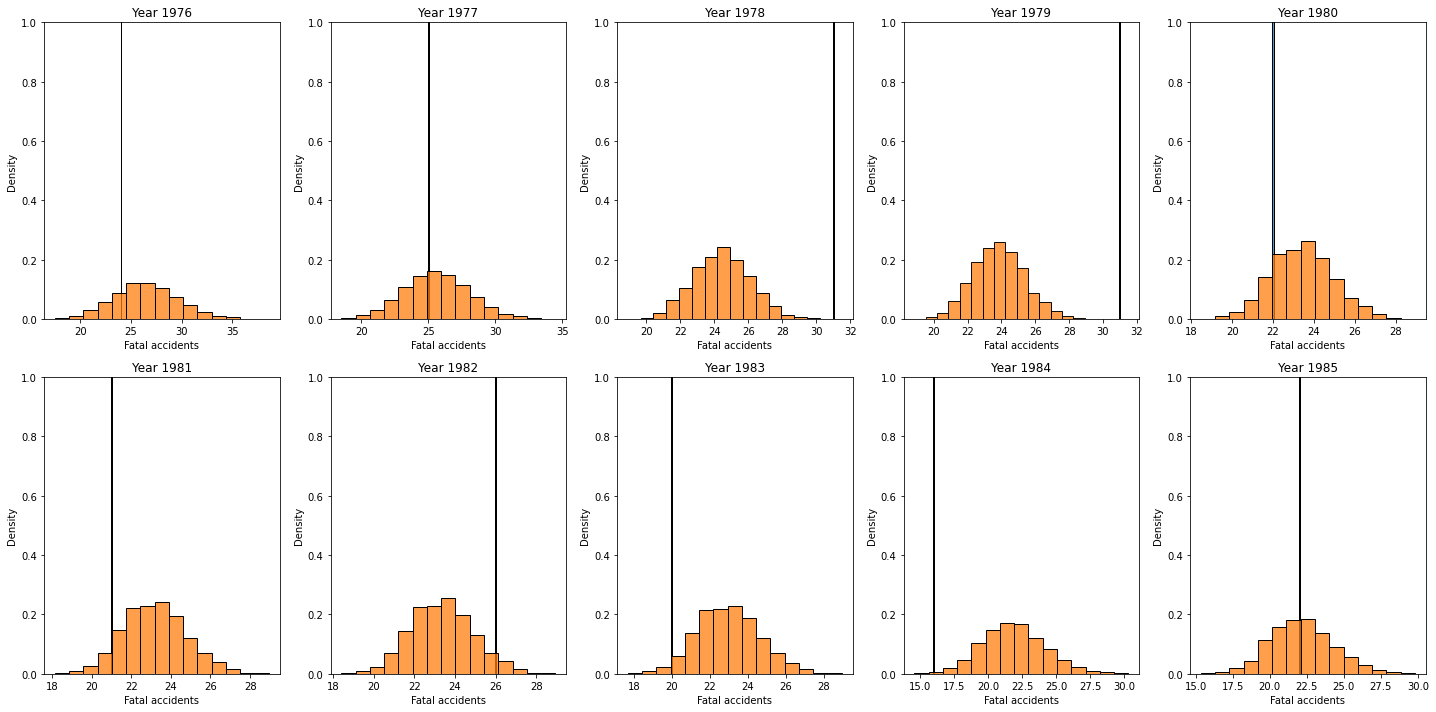

In [54]:
import seaborn as sns
# Plot the prior predictive distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(fit.draws_pd().loc[:, 'lambda[1]':'lambda[10]'].values, stat='density', ax=ax)
ax.set_xlabel('lambda')
ax.set_title('Prior Predictive Distribution')
plt.show()

# Fit the model to data
stan_data = {'N': len(airline_data['Fatal accidents']), 'y': airline_data['Fatal accidents'].values, 'n': airline_data['Miles flown [100 mln miles]'].values}
fit = poisson_model.sample(data=stan_data)

# Posterior predictive analysis
posterior_pred = fit.stan_variables()['lambda']

# Compare histograms of accidents for entire period and for each year
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
for i, year in enumerate(airline_data['Year']):
    sns.histplot(airline_data[airline_data['Year'] == year]['Fatal accidents'], bins=15, stat='density', ax=axes[i])
    sns.histplot(posterior_pred[:, i], bins=15, stat='density', ax=axes[i])
    axes[i].set_xlabel('Fatal accidents')
    axes[i].set_title(f'Year {year}')
    axes[i].set_ylim(0, 1)
    
plt.tight_layout()
plt.show()